# Import Libraries


In [1]:
import pandas as pd
import numpy as np
import nltk
import tensorflow as tf
from keras.layers import *
from tensorflow import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import *
import arabicstopwords.arabicstopwords as stp
from keras.preprocessing.sequence import pad_sequences
import re
import os
from camel_tools.tokenizers.word import simple_word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import wordnet
import warnings
from camel_tools.utils.dediac import dediac_ar
from camel_tools.utils.normalize import normalize_unicode
from camel_tools.utils.normalize import normalize_alef_maksura_ar
from camel_tools.utils.normalize import normalize_alef_ar
from camel_tools.utils.normalize import normalize_teh_marbuta_ar
import random
import emoji
import qalsadi.lemmatizer
from wordcloud import WordCloud
import plotly.express as px
import arabic_reshaper
from bidi.algorithm import get_display
from plotly import graph_objects as go
from collections import Counter
import string
pd.options.display.max_rows = 100
pd.options.display.max_columns =None 
random.seed(10)
tf.random.set_seed(10)

In [2]:
colors1 = ['#78e16b','#35d221']
colors2 = ['#1fce09', '#159006']
color3 = ['Salmon', 'FireBrick', 'MediumVioletRed', 'Tomato', 'Orange', 'Gold', 'DarkKhaki', 'Lavender', 'Plum', 'LimeGreen', 'MediumSpringGreen', 'Green', 'DeepSkyBlue', 'Aquamarine', 'MediumSlateBlue']

# Download Some Packages

In [3]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/osamaanmar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Ignore Warnings

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings(action='ignore')

# Read Data

In [5]:
df1 = pd.read_csv('dev.csv')
df2 = pd.read_csv('train.csv')
df3 = pd.read_csv('test.csv')
Corpus = pd.concat([df1, df2, df3], ignore_index=True)
Corpus.drop('clean_txt', inplace=True, axis=1)
Corpus.rename(columns={'sentiment': 'Sentiment', 'txt': 'Text'}, inplace=True)
Corpus.tail(5)

,Sentiment,Text
16434,Negative,بين الشفقة و العطف أقيم هذه الرواية يؤسفني جد...
16435,Negative,"أوصيك بالدقة . لا بالوضوح . "" فاليري"" تقريباً..."
16436,Negative,للاسف الشديد لم يعجبني الكتاب ، شعرت بالملل م...
16437,Positive,من بداية الرواية وانا احاول تمالك نفسي ولكن ت...
16438,Negative,خذلتنى هذه الرواية كثيرا لم يعجبنى ابدا تداخل...


# Percantage Of Each Sentiment

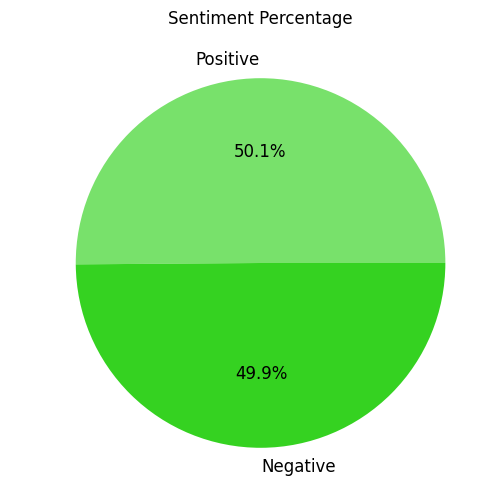

In [6]:
Corpus['Sentiment'].value_counts().plot.pie(autopct = '%0.1f%%',
                                                    textprops = {'size': 'large'},
                                                    title = 'Sentiment Percentage',
                                                    figsize = (6,6),
                                                    colors = colors1,
                                                    ylabel = ' ');

# Count Of Each Sentiment

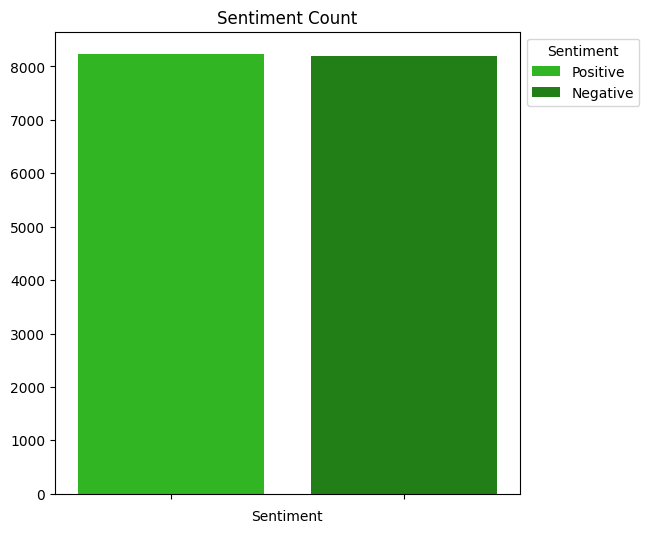

In [7]:
ax, fig = plt.subplots(figsize = (6,6))
ax =sns.countplot(x='Sentiment', data=Corpus, dodge=False, hue='Sentiment',  order= Corpus['Sentiment'].value_counts().index, hue_order =Corpus['Sentiment'].value_counts().index,  palette=colors2);
ax.set(xticklabels=[]) 
ax.set(ylabel=None) 
plt.title('Sentiment Count')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

# Number Of Sentences

In [8]:
Corpus['NumberOfSentences'] = Corpus['Text'].apply(lambda n:len(nltk.tokenize.sent_tokenize(n)))
Corpus.drop(Corpus[ Corpus["NumberOfSentences"] == 0].index, inplace = True)
Corpus['NumberOfSentences'].sum()

48524

# Average Number Of Sentences

In [9]:
AverageNumberOfSentence = int(np.round(Corpus["NumberOfSentences"].mean()))
AverageNumberOfSentence

3

# Maximum Number Of Sentences

In [10]:
MaximumNumberOfSentence = Corpus["NumberOfSentences"].max()
MaximumNumberOfSentence

326

# Minimum Number Of Sentences

In [11]:
MinimumNumberOfSentence = Corpus["NumberOfSentences"].min()
MinimumNumberOfSentence

1

# Text Normalization

In [12]:
def remove_emojis(text):
     "Remove All Emojis From Text"
     text = emoji.replace_emoji(text, replace="")
     return text

def remove_hashtags(text):
     "Remove All Hashtags From Text"
     text =  re.sub("#[ا-ي٠-٩a-zA-Z0-9]+","", text)
     return text   

def remove_emails(text):
     "Remove All Emails From Text"
     text = re.sub("[a-zA-Z0-9-_.]+@[a-zA-Z]+.[a-zA-Z]+","", text)  
     return text    

def remove_url(text):
     "Remove All URL From Text"
     text = re.sub(r'http\S+', '', text, flags=re.MULTILINE)
     return text

def remove_mention(text):
     "Remove All Mention From Text"
     text = re.sub("@[ا-ي٠-٩a-zA-Z0-9]+","", text)
     return text

def remove_duplicate_char(text):
     "Remove Chars Word Has More Than 2 Same Following Char"
     text = re.sub(r'(.)\1+', r'\1\1', text)
     return text

def remove_single_char(text):
     "Remove Alone Chars From Text"
     text = ' '.join( [w for w in text.split() if len(w)>1] )
     return text

def remove_special_character_(text):
     "Remove Special Character From Text"
     Punctuations = '`؛،؟.,«»÷-' + string.punctuation
     for punctuation in Punctuations:
        text = text.replace(punctuation, ' ')
     return text   

def remove_new_line_char(text):
     "Remove New Line Symbols From Text"
     text = text.replace('\n', ' ')
     return text  
 
def remove_number(text):
     "Remove All Number From Text"
     text = re.sub(r'\d+', '', text)
     return text

def remove_html_tags(text):
    "Remove All HTL Tags From Text"
    text = re.sub("<.*?>", ' ', text)
    return text

def remove_arabic_diacritics_(text):
     "Remove Arabic Dediacritization"
     text = dediac_ar(text)
     return text

def normalize_arabic_unicode_(text):
     "Converts A Composed Character Into Its Decomposed Form"
     text = normalize_unicode(text)
     return text

def normalize_alef_maksura_ar_(text):
     "Normalize alef maksura 'ى' to yeh 'ي'"
     text = normalize_alef_maksura_ar(text)
     return text

def normalize_alef_ar_(text):
     "Normalize alef variants to 'ا'"
     text = normalize_alef_ar(text)
     return text

def normalize_teh_marbuta_ar_(text):
     "Normalize teh marbuta 'ة' to heh 'ه'"
     text = normalize_teh_marbuta_ar(text)
     return text

def remove_non_arabic(text):
    "Remove Non Arabic Word And Char"
    text = re.sub('[a-zA-Z]', '', text)
    return text

def remove_whitespace(text):
     "Remove Extra WhiteSpace"
     text = text.strip()
     return text 

def remove_unicode_characters_(text):
     "Remove Unicode Char"
     for character in text:
        if (ord(character) < 47) or ((ord(character) > 123 and ord(character) < 1568)) or ((ord(character) > 1641 and ord(character) < 8239)) :
         text = text.replace(character, ' ')
     return text

def remove_longest_than_(text):
     "Remove All Words That Longest Than The Longest Word In Arabic"
     for word in text.split():
          if len(word) >=16:
               text = text.replace(word, '')
     return text

def remove_stop_words(text):
     "Remove StopWords From Text"
     StopWords1 = set(stp.stopwords_list())
     StopWords2 = set(open('ArabicStopWord.txt','r', encoding='Utf-8').read().split('\n'))
     StopWords = StopWords1.union(StopWords2)
     text = simple_word_tokenize(text)
     text = [word for word in text if word not in StopWords]
     return ' '.join(text)

In [13]:
def text_normalization(text):
    text = remove_emojis(text) 
    text = remove_non_arabic(text)
    text = remove_duplicate_char(text)
    text = remove_number(text)
    text = remove_html_tags(text)
    text = normalize_arabic_unicode_(text)
    text = remove_single_char(text)
    text = remove_special_character_(text)
    text = remove_stop_words(text)
    text = normalize_alef_ar(text)
    text = normalize_alef_maksura_ar(text)
    text = normalize_teh_marbuta_ar(text)
    text = remove_arabic_diacritics_(text)
    text = remove_longest_than_(text)
    text = remove_new_line_char(text)
    text = remove_whitespace(text)
    return ''.join(text)

In [14]:
Corpus['Normalized_Text'] = Corpus['Text'].apply(lambda x: text_normalization(x))
Corpus.tail(5)

,Sentiment,Text,NumberOfSentences,Normalized_Text
16434,Negative,بين الشفقة و العطف أقيم هذه الرواية يؤسفني جد...,1,الشفقه العطف اقيم الروايه يؤسفني معاناه محمد ش...
16435,Negative,"أوصيك بالدقة . لا بالوضوح . "" فاليري"" تقريباً...",3,اوصيك بالدقه بالوضوح فاليري ابراهيم اصلان نفذ ...
16436,Negative,للاسف الشديد لم يعجبني الكتاب ، شعرت بالملل م...,2,للاسف الشديد يعجبني الكتاب شعرت بالملل الصفحات...
16437,Positive,من بداية الرواية وانا احاول تمالك نفسي ولكن ت...,14,بدايه الروايه وانا احاول تمالك تعاندني عبرات م...
16438,Negative,خذلتنى هذه الرواية كثيرا لم يعجبنى ابدا تداخل...,1,خذلتني الروايه يعجبني ابدا تداخل قصتي الكاتب و...


# Number Of Unique Words

In [15]:
UniqueWords = set()
for word in Corpus['Normalized_Text'].str.split():
    UniqueWords.update(word)
len(UniqueWords)

74035

# WordCloud

In [16]:
def word_cloud_(Sentiment):
    text = str(Corpus[Corpus['Sentiment'] == Sentiment]['Normalized_Text'])
    text = arabic_reshaper.reshape(text)
    text = get_display(text)
    wordcloud = WordCloud(font_path='arial.ttf',background_color='white', mode='RGB',width=1200,height=600).generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation='catrom')
    plt.axis("off")
    plt.title('Word Cloud For {} Sentiment'.format(Sentiment))
    plt.show()

**1-Positive**

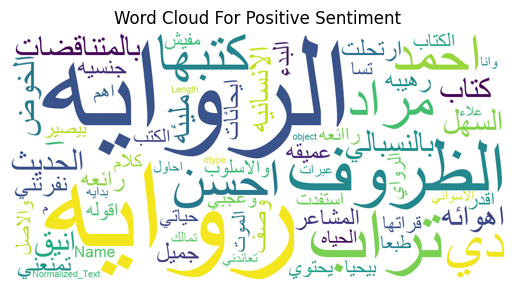

In [17]:
word_cloud_('Positive')

**2-Negative**

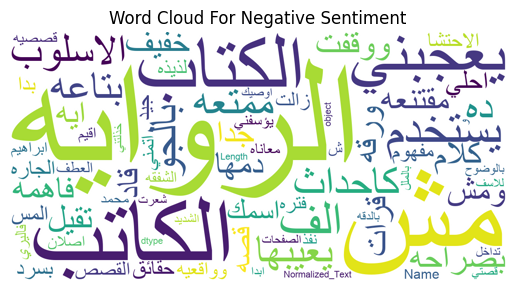

In [18]:
word_cloud_('Negative')

# Most Frequent Words 

In [19]:
MostFrequentWord = Counter((Corpus['Normalized_Text']).str.split().explode()).most_common(15)
MostFrequentWordDF = pd.DataFrame(MostFrequentWord, columns=('Word', 'Count'))
MostFrequentWordDF

,Word,Count
0,الروايه,7347
1,الكتاب,6617
2,كتاب,3828
3,روايه,3154
4,الكاتب,2793
5,الله,2312
6,اللي,1878
7,مش,1444
8,رائع,1431
9,الاحداث,1247


In [20]:
fig = go.Figure(go.Funnel(
    y = MostFrequentWordDF['Word'].tolist(),
    x = MostFrequentWordDF['Count'].tolist(),
    marker = {"color": color3}))
fig.show()

In [21]:
fig = px.bar(MostFrequentWordDF, y='Word', x='Count',  orientation='h')
fig.show()

# Number Of Words 

In [22]:
Corpus["Number of Words"] = Corpus["Normalized_Text"].apply(lambda n:len(simple_word_tokenize(n)))
Corpus.drop(Corpus[ Corpus["Number of Words"] == 0].index, inplace = True)
Corpus["Number of Words"].sum()

569211

# Number Of Charachters 

In [23]:
Corpus["Number of Charachters"] = Corpus["Normalized_Text"].str.len()
Corpus["Number of Charachters"].sum()

3543446

# Average Number Of Words 

In [24]:
AverageNaumberOfWords = int(np.round((Corpus["Number of Words"].mean())))
AverageNaumberOfWords

35

# Average Number Of Charachters 

In [25]:
AverageNumberOfCharachters = int(np.round(Corpus["Number of Charachters"].mean()))
AverageNumberOfCharachters

216

# Maximum Number Of Word

In [26]:
MaximumNaumberOfWords = Corpus["Number of Words"].max()
MaximumNaumberOfWords

1853

# Maximum Number Of Charachters 

In [27]:
MaximumNumberOfCharachters = Corpus['Number of Charachters'].max() 
MaximumNumberOfCharachters

11593

# Minimum Number Of Words

In [28]:
MimimumNaumberOfWords = Corpus["Number of Words"].min()
MimimumNaumberOfWords

1

# Minimum Number Of Charachters 

In [29]:
MinimumNumberOfCharachters = int(Corpus['Number of Charachters'].mean() )
MinimumNumberOfCharachters

215

# Split The DataSet Into Independent Variables , And Dependent Variable (Y)

In [30]:
X= Corpus['Normalized_Text']
y = Corpus['Sentiment']

# Label Encoder

In [31]:
y = y.map({'Negative': 0, 'Positive': 1})

# Split The Dataset Into Training And Testing

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=44)

# TfidfVectorizer

In [33]:
Tfidf = TfidfVectorizer()
X_train_Tfidf = Tfidf.fit_transform(X_train)
X_test_Tfidf = Tfidf.transform(X_test)

In [34]:
vocab = Tfidf.vocabulary_
vocab

{'سيناريو': 30772,
 'فيلم': 35960,
 'عربي': 33000,
 'ساذج': 29583,
 'فشل': 35146,
 'روايه': 29154,
 'مثيره': 44379,
 'استمتعت': 2533,
 'جيد': 26175,
 'قراءه': 36337,
 'الروايه': 8265,
 'اكره': 4350,
 'البطل': 5895,
 'جاء': 25442,
 'التقييم': 6584,
 'درااما': 27927,
 'ملهاش': 46924,
 'اي': 15373,
 'لازمه': 38398,
 'تعجبني': 23588,
 'ابدا': 141,
 'كتبت': 37242,
 'طريقه': 32284,
 'الخواطر': 7732,
 'غازي': 33689,
 'القصيبي': 10712,
 'اجتر': 790,
 'طوال': 32387,
 'القصه': 10707,
 'مليئه': 46950,
 'بالمعاناه': 17159,
 'والماساه': 52883,
 'يوجد': 63935,
 'احداث': 1084,
 'تشد': 23064,
 'انتباه': 14482,
 'القارئ': 10538,
 'مجرد': 44459,
 'مذكرات': 45036,
 'لمصاب': 42171,
 'بالزهايمر': 16623,
 'اسوا': 2803,
 'قرات': 36356,
 'لغازي': 40318,
 'الاسف': 4934,
 'حاولت': 26331,
 'اتحشي': 365,
 'الكتاب': 10896,
 'لشعوري': 40046,
 'بسيط': 18907,
 'اضطررت': 3185,
 'لقراءته': 40489,
 'بناء': 20167,
 'طلب': 32345,
 'البوك': 6003,
 'كلاب': 37666,
 'اللي': 11234,
 'مشتركه': 45690,
 'كتاب': 37209,
 'خفيف': 27

# Models

In [35]:
def models_(model_name):
    model = model_name
    model.fit(X_train_Tfidf, y_train)
    y_pred = model.predict(X_test_Tfidf)
    return y_pred

# Confusion Matrix

In [36]:
def confusion_matrix_(y_pred):
        ConfusionMatrix = confusion_matrix(y_test, y_pred)
        return ConfusionMatrix

# Generate True Positive, False Positive, True Negative, False Negative

In [37]:
def positive_negative(Confusin_Matrix):
    False_Postive = Confusin_Matrix[0, 1]

    True_Positive = Confusin_Matrix[0, 0]

    False_Negative = Confusin_Matrix[1, 0]
    
    True_Negative = Confusin_Matrix[1, 1]

    return False_Postive, True_Positive, False_Negative, True_Negative

# Performance Merics

In [38]:
def performance_metrics(False_Postive, True_Positive, False_Negative, True_Negative):
     Accuracy = (True_Positive + True_Negative) / (True_Positive + True_Negative + False_Postive + False_Negative)
     Precision = True_Positive / (True_Positive+ False_Postive)
     Sensitivity = True_Positive / (True_Positive  + False_Negative)
     Specificity = True_Negative / (True_Negative + False_Negative)
     F1Score = (True_Positive) / ((True_Positive) + (0.5 *(False_Postive + False_Negative)))
     Error = 1 - Accuracy
     MetricsValues = pd.DataFrame(index=['Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1Score', 'Error'], columns=['Values'], data=[Accuracy, Precision, Sensitivity, Specificity, F1Score, Error])
     return MetricsValues


# Machine Learning

**1. Naive Bayes**

In [39]:
model_name1 = MultinomialNB()
y_pred1 = models_(model_name1)

In [40]:
cm1 = confusion_matrix_(y_pred1)

In [41]:
False_Postive, True_Positive, False_Negative, True_Negative = positive_negative(cm1)

In [42]:
MetricsValues1 = performance_metrics(False_Postive, True_Positive, False_Negative, True_Negative)

In [43]:
MetricsValues1

,Values
Accuracy,0.893509
Precision,0.884367
Sensitivity,0.902178
Specificity,0.902778
F1Score,0.893184
Error,0.106491


**2. Logistic Regression**

In [44]:
model_name2 = LogisticRegression()
y_pred2 = models_(model_name2)

In [45]:
cm2 = confusion_matrix_(y_pred2)

In [46]:
False_Postive2, True_Positive2, False_Negative2, True_Negative2 = positive_negative(cm2)
MetricsValues2 = performance_metrics(False_Postive2, True_Positive2, False_Negative2, True_Negative2)
MetricsValues2

,Values
Accuracy,0.886613
Precision,0.890008
Sensitivity,0.885371
Specificity,0.883170
F1Score,0.887683
Error,0.113387


**3. Decision Tree**

In [47]:
model_name3 = DecisionTreeClassifier(criterion = 'entropy')
y_pred3 = models_(model_name3)

In [48]:
cm3 = confusion_matrix_(y_pred3)

In [49]:
False_Postive3, True_Positive3, False_Negative3, True_Negative3 = positive_negative(cm3)
MetricsValues3 = performance_metrics(False_Postive3, True_Positive3, False_Negative3, True_Negative3)
MetricsValues3

,Values
Accuracy,0.839351
Precision,0.831587
Sensitivity,0.846596
Specificity,0.847222
F1Score,0.839024
Error,0.160649


**4. K Nearest Neighbor**

In [50]:
model_name4 = KNeighborsClassifier(metric='cosine', n_neighbors=5)
y_pred4 = models_(model_name4)

In [51]:
cm4 = confusion_matrix_(y_pred4)

In [52]:
False_Postive4, True_Positive4, False_Negative4, True_Negative4 = positive_negative(cm4)
MetricsValues4 = performance_metrics(False_Postive4, True_Positive4, False_Negative4, True_Negative4)
MetricsValues4

,Values
Accuracy,0.801014
Precision,0.727639
Sensitivity,0.855519
Specificity,0.875408
F1Score,0.786414
Error,0.198986


**5. Random Forest**

In [53]:
model_name5 = RandomForestClassifier(criterion = 'entropy', n_estimators=100)
y_pred5 = models_(model_name5)

In [54]:
cm5 = confusion_matrix_(y_pred5)

In [55]:
False_Postive5, True_Positive5, False_Negative5, True_Negative5 = positive_negative(cm5)
MetricsValues5 = performance_metrics(False_Postive5, True_Positive5, False_Negative5, True_Negative5)
MetricsValues5

,Values
Accuracy,0.881542
Precision,0.903304
Sensitivity,0.866976
Specificity,0.859477
F1Score,0.884767
Error,0.118458


**6.SGD Classifier**

In [56]:
model_name6 = SGDClassifier(loss='hinge')
y_pred6 = models_(model_name6)

In [57]:
cm6 = confusion_matrix_(y_pred6)

In [58]:
False_Postive6, True_Positive6, False_Negative6, True_Negative6 = positive_negative(cm6)
MetricsValues6 = performance_metrics(False_Postive6, True_Positive6, False_Negative6, True_Negative6)
MetricsValues6

,Values
Accuracy,0.895740
Precision,0.889202
Sensitivity,0.902289
Specificity,0.902369
F1Score,0.895698
Error,0.104260


# Deep Learning

In [59]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
embedding_dim = 16
vocab_size = len(tokenizer.word_index) + 1
vocab_size

74036

In [60]:
X_train_seqs = tokenizer.texts_to_sequences(X_train)
X_test_seqs = tokenizer.texts_to_sequences(X_test)
max_length = len(max(X_train_seqs, key=len))
max_length

1853

In [61]:
encoded_X_train = pad_sequences(X_train_seqs, maxlen=max_length)
encoded_X_test = pad_sequences(X_test_seqs, maxlen=max_length)

In [62]:
y_train_enc = keras.utils.to_categorical(y_train)
y_test_enc = keras.utils.to_categorical(y_test)

In [63]:
Callback = tf.keras.callbacks.EarlyStopping(
                    monitor="accuracy",
                    mode="max",
                    patience=0
                )

**7-Convolutional Neural Network**

In [64]:
model = tf.keras.Sequential([
                Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
                Conv1D(filters=32, kernel_size = 3, activation='relu'),
                GlobalAveragePooling1D(),
                Dropout(0.8),
                Dense(1, activation= 'sigmoid')
                ])

In [65]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [66]:
history = model.fit(encoded_X_train, y_train,
                    epochs=20,
                    validation_data=(encoded_X_test, y_test),
                    batch_size=16,
                    callbacks=[Callback])

Epoch 1/20
719/719 [==============================] - 132s 183ms/step - loss: 0.6934 - accuracy: 0.5045 - val_loss: 0.6916 - val_accuracy: 0.5598
Epoch 2/20
719/719 [==============================] - 83s 115ms/step - loss: 0.6710 - accuracy: 0.6901 - val_loss: 0.6453 - val_accuracy: 0.7110
Epoch 3/20
719/719 [==============================] - 87s 120ms/step - loss: 0.5616 - accuracy: 0.7933 - val_loss: 0.5310 - val_accuracy: 0.8187
Epoch 4/20
719/719 [==============================] - 90s 125ms/step - loss: 0.4122 - accuracy: 0.8791 - val_loss: 0.4217 - val_accuracy: 0.8471
Epoch 5/20
719/719 [==============================] - 80s 111ms/step - loss: 0.3018 - accuracy: 0.9157 - val_loss: 0.3564 - val_accuracy: 0.8684
Epoch 6/20
719/719 [==============================] - 77s 108ms/step - loss: 0.2328 - accuracy: 0.9377 - val_loss: 0.3175 - val_accuracy: 0.8828
Epoch 7/20
719/719 [==============================] - 81s 112ms/step - loss: 0.1855 - accuracy: 0.9509 - val_loss: 0.2949 - val_a

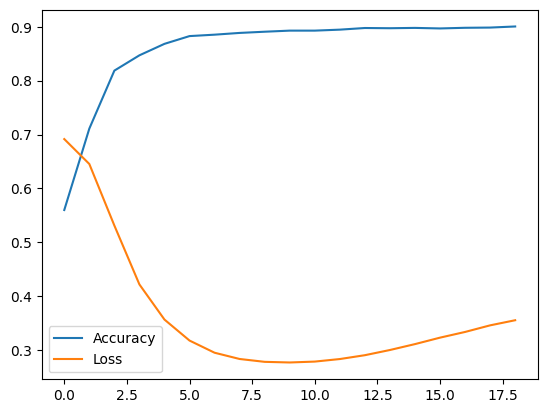

In [67]:
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(val_acc, label='Accuracy')
plt.plot(val_loss, label='Loss')
plt.legend()
plt.show()

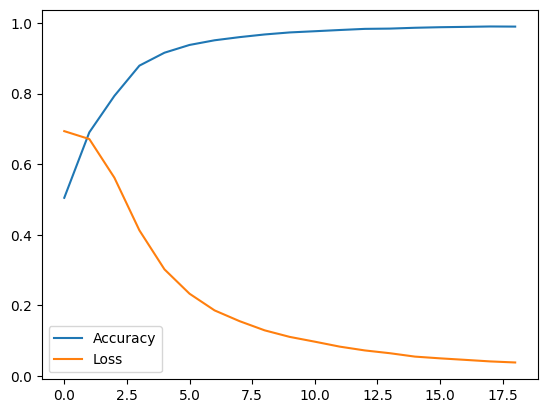

In [68]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.plot(acc, label='Accuracy')
plt.plot(loss, label='Loss')
plt.legend()
plt.show()

In [69]:
loss, accuracy = model.evaluate(encoded_X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(encoded_X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9918
Testing Accuracy:  0.9006


**8-Recurrent Neural Networks (LSTM)**

In [70]:
model = tf.keras.Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        LSTM(64, return_sequences=False),    
        Dropout(0.2),
        Dense(1, activation='sigmoid')])

In [71]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [72]:
history = model.fit(encoded_X_train, y_train,
                    epochs=20,
                    validation_data=(encoded_X_test, y_test),
                    batch_size=16,
                    callbacks=[Callback])

Epoch 1/20
719/719 [==============================] - 123s 168ms/step - loss: 0.4948 - accuracy: 0.7555 - val_loss: 0.3379 - val_accuracy: 0.8473
Epoch 2/20
719/719 [==============================] - 127s 177ms/step - loss: 0.1435 - accuracy: 0.9498 - val_loss: 0.3219 - val_accuracy: 0.8775
Epoch 3/20
719/719 [==============================] - 138s 192ms/step - loss: 0.0427 - accuracy: 0.9867 - val_loss: 0.3878 - val_accuracy: 0.8773
Epoch 4/20
719/719 [==============================] - 131s 182ms/step - loss: 0.0200 - accuracy: 0.9939 - val_loss: 0.4757 - val_accuracy: 0.8836
Epoch 5/20
719/719 [==============================] - 121s 168ms/step - loss: 0.0111 - accuracy: 0.9966 - val_loss: 0.5730 - val_accuracy: 0.8789
Epoch 6/20
719/719 [==============================] - 134s 187ms/step - loss: 0.0175 - accuracy: 0.9948 - val_loss: 0.4877 - val_accuracy: 0.8862


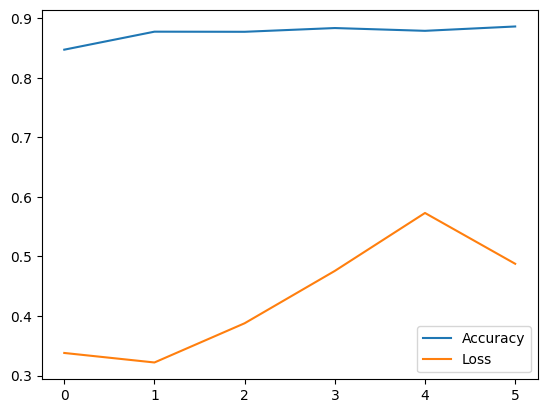

In [73]:
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(val_acc, label='Accuracy')
plt.plot(val_loss, label='Loss')
plt.legend()
plt.show()

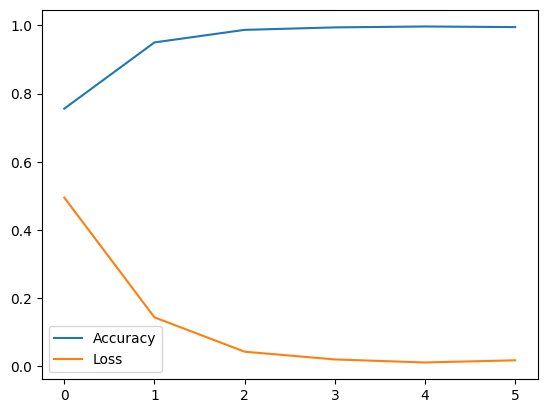

In [74]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.plot(acc, label='Accuracy')
plt.plot(loss, label='Loss')
plt.legend()
plt.show()

In [75]:
loss, accuracy = model.evaluate(encoded_X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(encoded_X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9978
Testing Accuracy:  0.8862
